In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "photos",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)  #68*32batch_size=2176 nearly 2152 -> simply number of data in one batch

68

In [6]:
for image_batch,label_batch in dataset.take(1): #give only one batch
    print(image_batch.shape)
    print(label_batch.numpy()) #every element we get is a tensor therefore we want to covert it to numpy 

(32, 256, 256, 3)
[1 2 1 1 1 1 0 1 1 0 1 1 2 0 2 2 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1]


In [7]:
for image_batch,label_batch in dataset.take(1): #give only one batch
    #print(image_batch)
    print(image_batch.numpy())

[[[[206. 203. 210.]
   [203. 200. 207.]
   [198. 195. 202.]
   ...
   [177. 175. 186.]
   [178. 176. 187.]
   [180. 178. 189.]]

  [[200. 197. 204.]
   [198. 195. 202.]
   [196. 193. 200.]
   ...
   [179. 177. 188.]
   [178. 176. 187.]
   [176. 174. 185.]]

  [[196. 193. 200.]
   [194. 191. 198.]
   [194. 191. 198.]
   ...
   [179. 177. 188.]
   [176. 174. 185.]
   [172. 170. 181.]]

  ...

  [[151. 146. 153.]
   [144. 139. 146.]
   [144. 139. 146.]
   ...
   [139. 136. 147.]
   [142. 138. 152.]
   [157. 153. 167.]]

  [[148. 143. 150.]
   [143. 138. 145.]
   [148. 143. 150.]
   ...
   [147. 144. 155.]
   [147. 143. 157.]
   [152. 148. 162.]]

  [[147. 142. 149.]
   [144. 139. 146.]
   [150. 145. 152.]
   ...
   [143. 140. 151.]
   [139. 135. 149.]
   [136. 132. 146.]]]


 [[[167. 162. 168.]
   [174. 169. 175.]
   [183. 178. 184.]
   ...
   [167. 161. 165.]
   [177. 171. 175.]
   [147. 141. 145.]]

  [[168. 163. 169.]
   [173. 168. 174.]
   [178. 173. 179.]
   ...
   [151. 145. 149.]
 

In [8]:
print(image_batch[0].shape)

(256, 256, 3)


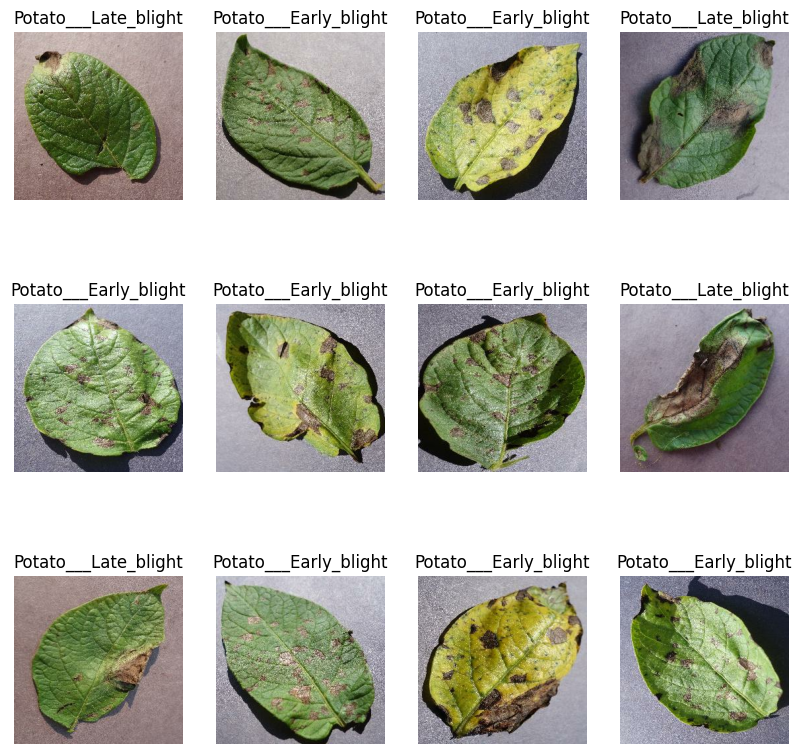

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1): #give only one batch
    for i in range(12):
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

68

In [11]:
#80% training
#20% => 10% validation 10% testing
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54) #arr(:54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54) #arr(54:)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds =test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),  #resize the image to 256*256 (if there is different type image it resize to this value)
    layers.Rescaling(1.0/255), #rescale the pixel values to the range [0, 1].
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), #flipping should occur both horizontally and vertically.
    layers.RandomRotation(0.2) #images will be rotated by a random angle in the range of -20% to 20% of a full circle
])

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape = input_shape)

C:\Users\sudee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 640ms/step - accuracy: 0.4756 - loss: 0.9428 - val_accuracy: 0.4948 - val_loss: 0.8728
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - accuracy: 0.6162 - loss: 0.8149 - val_accuracy: 0.7292 - val_loss: 0.5977
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.7957 - loss: 0.5063 - val_accuracy: 0.8698 - val_loss: 0.4153
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 541ms/step - accuracy: 0.8358 - loss: 0.3958 - val_accuracy: 0.8802 - val_loss: 0.4201
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 519ms/step - accuracy: 0.8780 - loss: 0.2987 - val_accuracy: 0.8854 - val_loss: 0.3522
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 551ms/step - accuracy: 0.8686 - loss: 0.3064 - val_accuracy: 0.8698 - val_loss: 0.3113
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 748ms/step - accuracy: 0.9070 - loss: 0.2285 - val_accuracy: 0.8229 - val_loss: 0.5033
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 641ms/step - accuracy: 0.9146 - loss: 0.2033 - val_accu

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9742 - loss: 0.0844


In [30]:
scores

[0.0829726904630661, 0.97265625]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
history.history['accuracy']

[0.5121527910232544,
 0.6857638955116272,
 0.8101851940155029,
 0.8530092835426331,
 0.8755787014961243,
 0.8761574029922485,
 0.9120370149612427,
 0.9189814925193787,
 0.9392361044883728,
 0.9328703880310059,
 0.9450231194496155,
 0.9560185074806213,
 0.9756944179534912,
 0.9629629850387573,
 0.9658564925193787,
 0.9681712985038757,
 0.9739583134651184,
 0.9652777910232544,
 0.984375,
 0.984375,
 0.9762731194496155,
 0.9751157164573669,
 0.9774305820465088,
 0.9837962985038757,
 0.9826388955116272,
 0.9884259104728699,
 0.9733796119689941,
 0.9710648059844971,
 0.9658564925193787,
 0.9913194179534912,
 0.9924768805503845,
 0.9704861044883728,
 0.9785879850387573,
 0.9901620149612427,
 0.9924768805503845,
 0.9832175970077515,
 0.9861111044883728,
 0.9942129850387573,
 0.9918981194496155,
 0.9809027910232544,
 0.9780092835426331,
 0.9901620149612427,
 0.9855324029922485,
 0.9971064925193787,
 0.9866898059844971,
 0.9780092835426331,
 0.9936342835426331,
 0.9884259104728699,
 0.994212985

In [35]:
len(history.history['accuracy'])

50

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

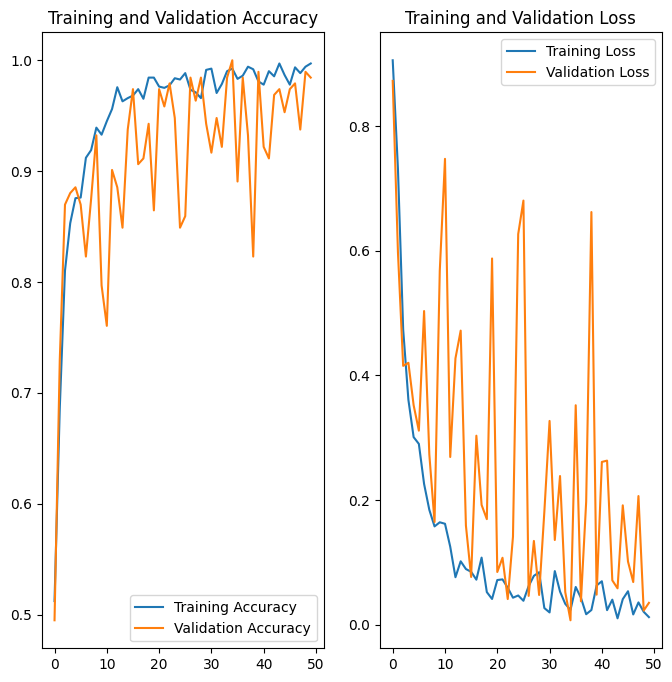

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
predicted label : Potato___Early_blight


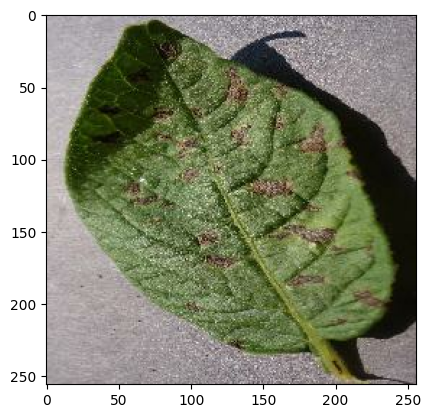

In [38]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label : ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label :" , class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


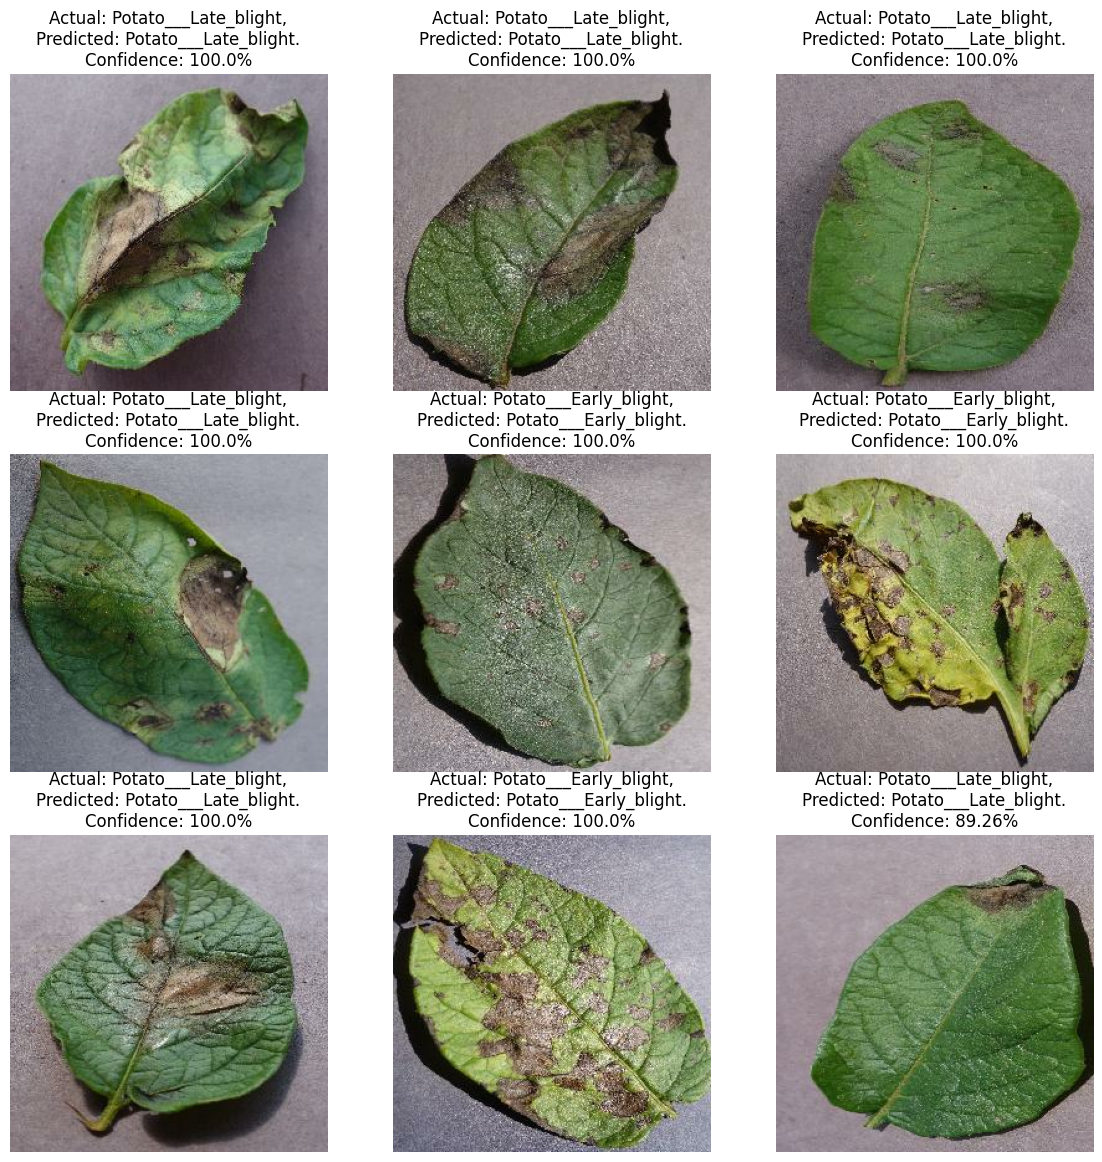

In [40]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        
        plt.axis("off")

In [41]:
import os
import re

# Directory containing the models
model_dir = "../Model"

# Get the list of files in the directory
files = os.listdir(model_dir)

# Define a regular expression pattern to match filenames like 'model_v1.keras'
pattern = re.compile(r'model_v(\d+)\.keras')

# Extract numeric parts and convert to integers
model_versions = [int(pattern.match(file).group(1)) for file in files if pattern.match(file)]

# Find the maximum version number and increment it
model_version = max(model_versions, default=0) + 1

# Save the model with the new version number
model.save(os.path.join(model_dir, f"{model_version}.keras"))

In [46]:
import os
import re

# Directory containing the models
model_dir = "../Model"

# Get the list of directories in the model_dir
existing_versions = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]

# Define a regular expression pattern to match numeric directory names
pattern = re.compile(r'^\d+$')

# Extract numeric parts and convert to integers
model_versions = [int(version) for version in existing_versions if pattern.match(version)]

# Find the maximum version number and increment it
model_version = max(model_versions, default=0) + 1

# Create a new directory for the new version
version_dir = os.path.join(model_dir, str(model_version))
os.makedirs(version_dir, exist_ok=True)

# Save the model in TensorFlow SavedModel format using model.export()
model.export(version_dir)

print(f"Model saved in directory: {version_dir}")


INFO:tensorflow:Assets written to: ../Model\4\assets


INFO:tensorflow:Assets written to: ../Model\4\assets


Saved artifact at '../Model\4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2844726416144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726422096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726424592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726425552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726425744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726426512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726426128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726426896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726425936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726426704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2844726424976: TensorSpec(shape=(), dtyp

end of the code

In [42]:
import os
import re
import tensorflow as tf

# Directory containing the models
model_dir = "../Model"

# Get the list of files in the directory
files = os.listdir(model_dir)

# Define a regular expression pattern to match filenames like 'model_v1.savedmodel'
pattern = re.compile(r'model_v(\d+)\.savedmodel')

# Extract numeric parts and convert to integers
model_versions = [int(pattern.match(file).group(1)) for file in files if pattern.match(file)]

# Find the maximum version number and increment it
model_version = max(model_versions, default=0) + 1

# Save the model with the new version number in TensorFlow SavedModel format
model.save(os.path.join(model_dir, f"{model_version}.savedmodel"), save_format='tf')

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../Model") + [0]]) + 1
model.save(f"../Model/{model_version}.h5")